In [35]:
#Librerias
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

#Introducción


La segmentación del corazón y los pulmones a partir de imágenes de radiografías de tórax es esencial para un diagnóstico preciso de la enfermedad, lo que permite el cálculo de biomarcadores digitales derivados de imágenes para la evaluación de la salud cardiopulmonar.
Esta base de datos presenta las segmentaciones de corazón y pulmón para 200 radiografías de tórax posterior-anterior MIMIC-CXR/MIMIC-CXR-JPG elegidas de forma semialeatoria con el fin de entrenar redes de detección y segmentación.

100 imagenes del corazón y 100 himagenes de pulmón

https://physionet.org/content/covid-19-thermal/1.1/#files-panel

##Leer carpeta de imagenes en drive

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Cargar imagen y clasificarlas

In [37]:
def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        if 'lungs' in folder:
            labels.append(0)  # Class 0 for lungs
        elif 'heart' in folder:
            labels.append(1)  # Class 1 for heart
    return np.array(images), np.array(labels)

#Ubicación de archivos
lung_path = '/content/drive/MyDrive/Colab Notebooks/Patrones/Challengue_N/lungs/'
heart_path = '/content/drive/MyDrive/Colab Notebooks/Patrones/Challengue_N/heart/'



##Cargar Imagenes

In [38]:
# Load images
num_images = 50  # Number of images to use from each class
lung_images, lung_labels = load_images_from_folder(lung_path)
heart_images, heart_labels = load_images_from_folder(heart_path)

##Concatenar y Normalizar

In [39]:
images = np.concatenate((lung_images[:num_images], heart_images[:num_images]), axis=0)
labels = np.concatenate((lung_labels[:num_images], heart_labels[:num_images]), axis=0)
images = images / 255

##Inicializar modelo

In [40]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Build the initial neural network model with multiple hidden layers
initial_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
initial_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


In [41]:
#Entrenar
initial_history = initial_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
3/3 [==============================] - 3s 731ms/step - loss: 0.2961 - accuracy: 0.7250 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 2s 645ms/step - loss: 1.4901e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 3s 980ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 2s 610ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 

##Evaluar modelo

1/1 [==============================] - 0s 332ms/step - loss: 0.0000e+00 - accuracy: 1.0000

Initial Test accuracy: 1.0

Initial Test loss: 0.0


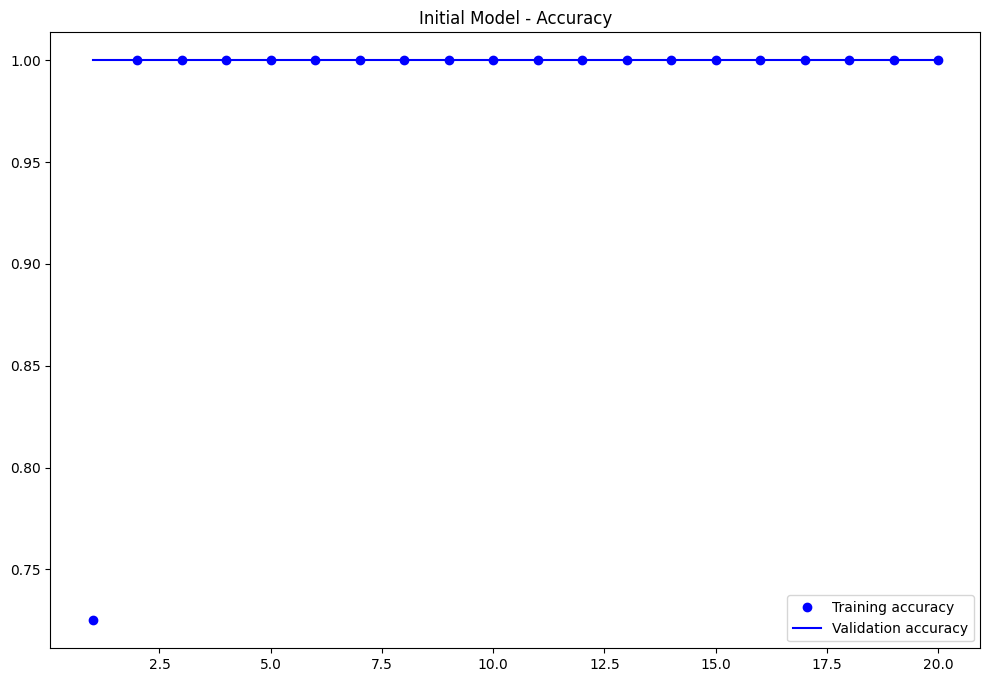

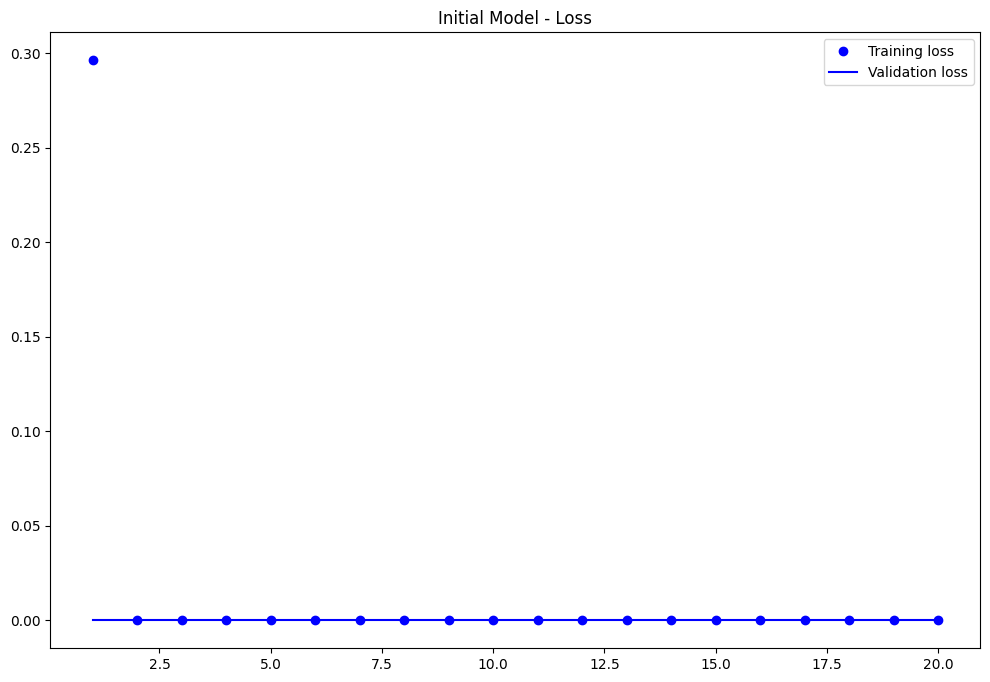

In [43]:
initial_test_loss, initial_test_acc = initial_model.evaluate(X_val, y_val)
print('\nInitial Test accuracy:', initial_test_acc)
print('\nInitial Test loss:', initial_test_loss)
import matplotlib.pyplot as plt
# Plot training and validation accuracy/loss
def plot_history(history, title):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(title + ' - Accuracy')
    plt.legend()
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title + ' - Loss')
    plt.legend()
    plt.show()

plot_history(initial_history, "Initial Model")

# Model with reduced layers, regularization, and dropout to handle overfitting
def build_and_train_model(layer_sizes, regularization, dropout_rate, epochs=20):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(256, 256, 1)))

    for size in layer_sizes:
        model.add(tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=regularization))
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

    test_loss, test_acc = model.evaluate(X_val, y_val)
    print(f'\nTest accuracy: {test_acc}')
    print(f'\nTest loss: {test_loss}')

    plot_history(history, f"Model with {len(layer_sizes)} layers, Reg: {regularization}, Dropout: {dropout_rate}")
    return model


Se muestra claramente que esta overfiteado el modelo, con outliners a simple vista

#Reduciendo capas, por Overfitting

Epoch 1/20
3/3 [==============================] - 3s 308ms/step - loss: 1.8199 - accuracy: 0.8875 - val_loss: 1.2972 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 0s 188ms/step - loss: 1.2488 - accuracy: 1.0000 - val_loss: 1.1629 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 0s 205ms/step - loss: 1.1558 - accuracy: 1.0000 - val_loss: 1.1530 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 0s 156ms/step - loss: 1.1574 - accuracy: 1.0000 - val_loss: 1.1668 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 0s 188ms/step - loss: 1.1656 - accuracy: 1.0000 - val_loss: 1.1532 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 0s 180ms/step - loss: 1.1426 - accuracy: 1.0000 - val_loss: 1.1067 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 1s 178ms/step - loss: 1.0905 - accuracy: 1.0000 - val_loss: 1.0441 - val_accuracy: 1.0000
Epoch 8/20
3/3 [====

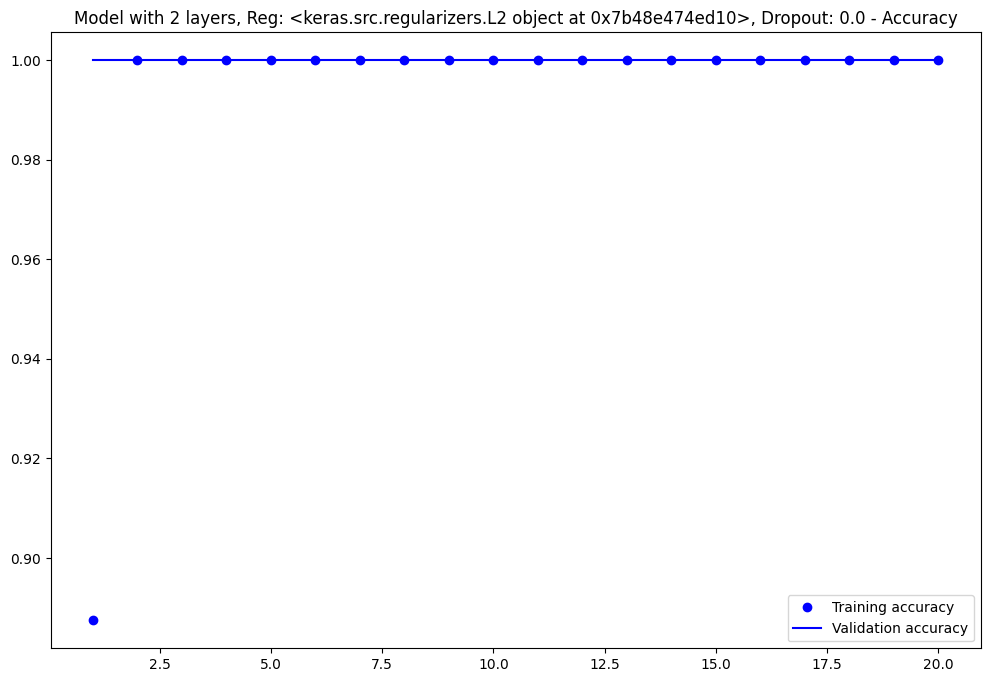

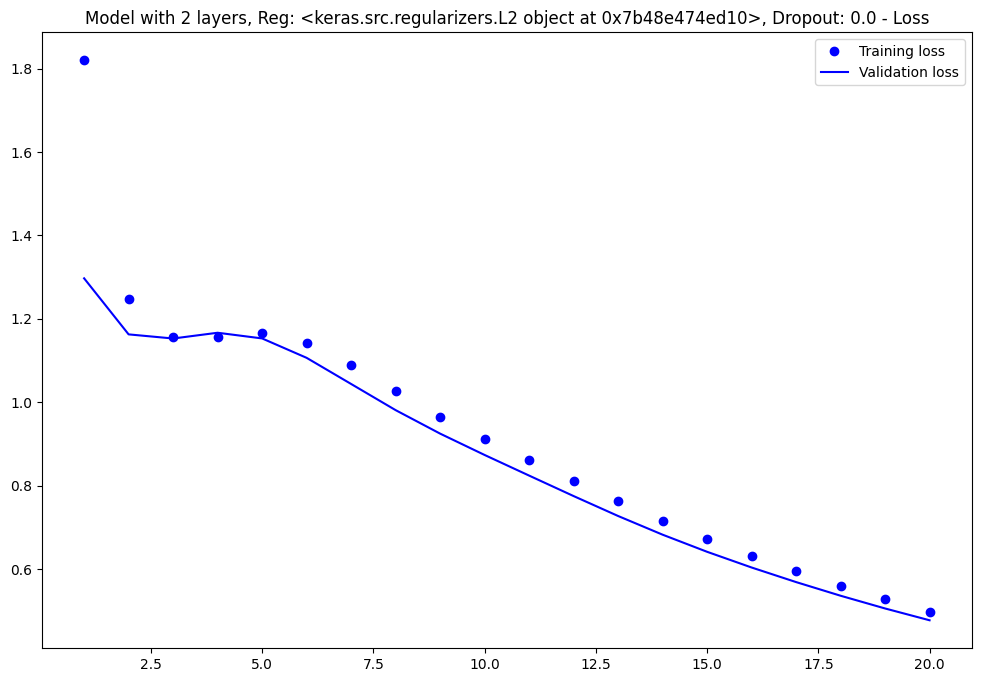

Epoch 1/20
3/3 [==============================] - 1s 204ms/step - loss: 2.4965 - accuracy: 0.5625 - val_loss: 1.2376 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 0s 82ms/step - loss: 1.5150 - accuracy: 0.9375 - val_loss: 1.0954 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 0s 85ms/step - loss: 1.5385 - accuracy: 0.9500 - val_loss: 1.1080 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 0s 84ms/step - loss: 1.6646 - accuracy: 0.9500 - val_loss: 1.1569 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 0s 80ms/step - loss: 1.1930 - accuracy: 0.9875 - val_loss: 1.1859 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 0s 91ms/step - loss: 1.2505 - accuracy: 0.9875 - val_loss: 1.1839 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 0s 80ms/step - loss: 1.1794 - accuracy: 1.0000 - val_loss: 1.1635 - val_accuracy: 1.0000
Epoch 8/20
3/3 [==========

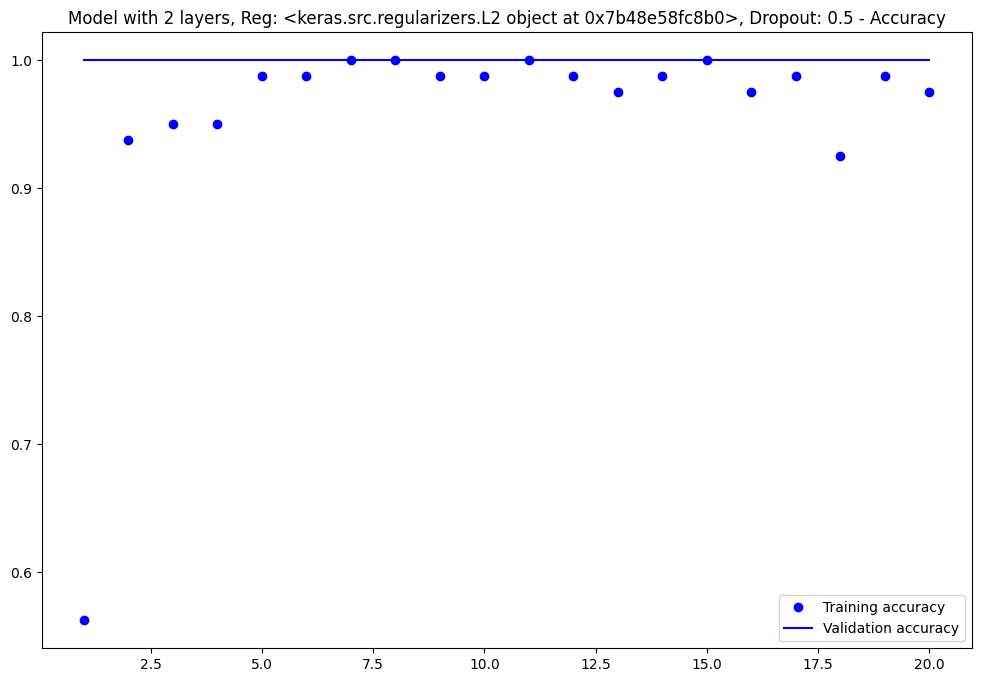

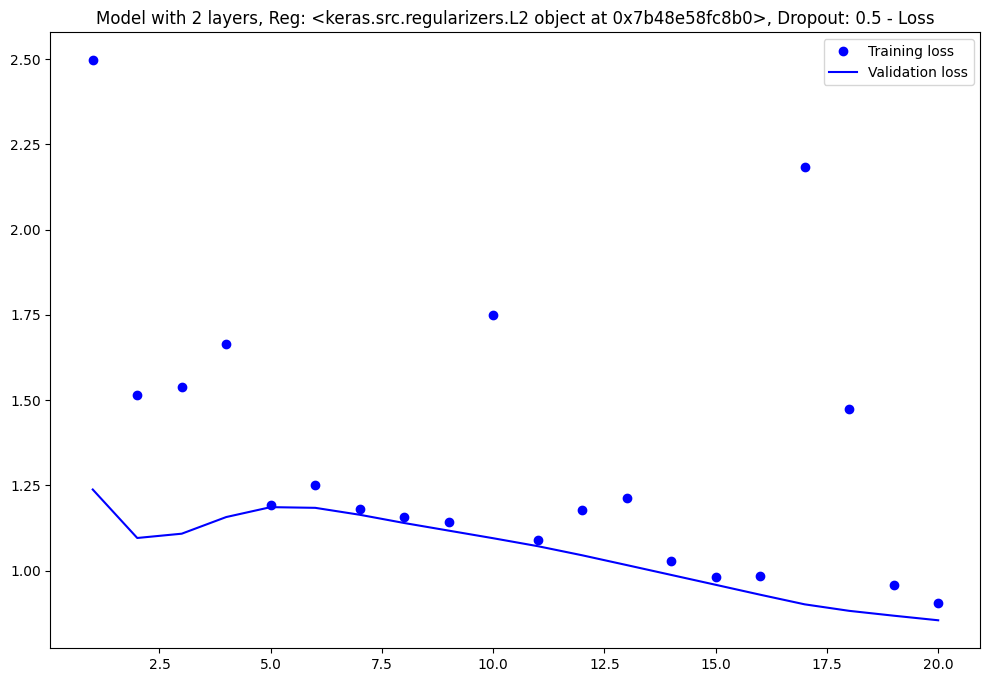

Epoch 1/20
3/3 [==============================] - 5s 1s/step - loss: 2.8594 - accuracy: 0.7500 - val_loss: 1.1929 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 2.1571 - accuracy: 0.9375 - val_loss: 1.0793 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 2s 718ms/step - loss: 1.7013 - accuracy: 0.9500 - val_loss: 1.0890 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 2s 733ms/step - loss: 2.0963 - accuracy: 0.9625 - val_loss: 1.1424 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 2s 719ms/step - loss: 1.1561 - accuracy: 1.0000 - val_loss: 1.1885 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 2s 718ms/step - loss: 1.3952 - accuracy: 0.9875 - val_loss: 1.2101 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 4s 2s/step - loss: 1.2118 - accuracy: 1.0000 - val_loss: 1.2131 - val_accuracy: 1.0000
Epoch 8/20
3/3 [=============

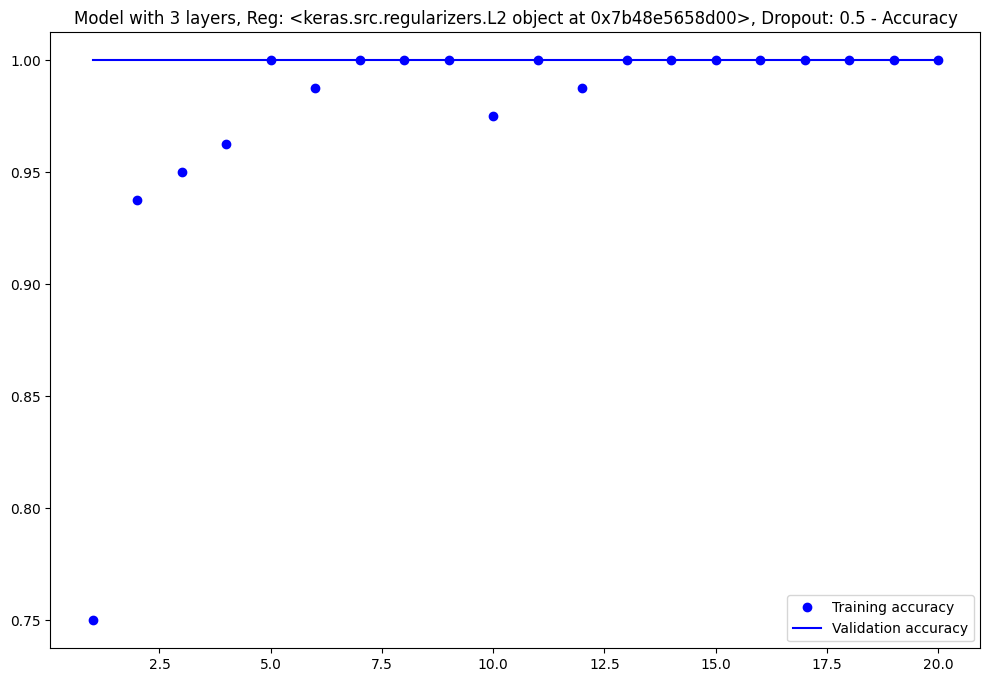

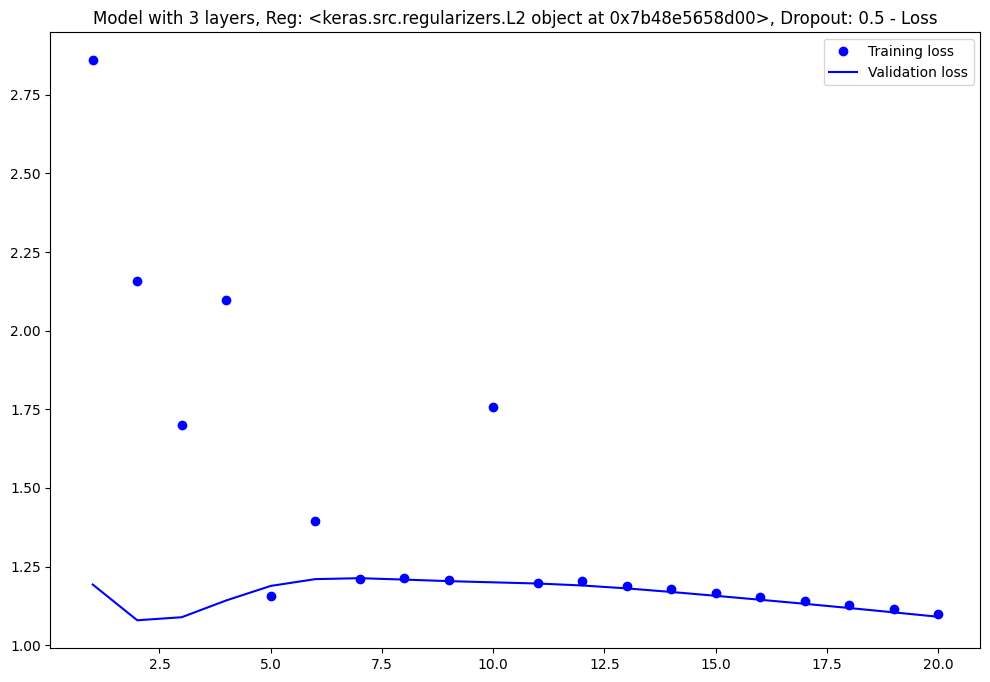

In [44]:
# Reduced layers and regularization
layer_sizes = [64, 32]
regularization = tf.keras.regularizers.l2(0.01)
dropout_rate = 0.0
build_and_train_model(layer_sizes, regularization, dropout_rate)

# Reduced layers, regularization, and dropout
layer_sizes = [64, 32]
regularization = tf.keras.regularizers.l2(0.01)
dropout_rate = 0.5
build_and_train_model(layer_sizes, regularization, dropout_rate)

# Original number of layers with regularization and dropout
layer_sizes = [512, 256, 128]
regularization = tf.keras.regularizers.l2(0.001)
dropout_rate = 0.5
build_and_train_model(layer_sizes, regularization, dropout_rate)

Como se puede apreciar el modelo de dos capas tiene la mejor tendencia y sentido de función de los datos.
Mientras más simple el modelo tiene mejores resultados